# Homework - Principal Components Analysis

## Libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import cm 
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


# 0. Preparation (Setting the Random State):

In [121]:
pellegrino = 331438
mungaicoppolino = 246120
rs = min(pellegrino, mungaicoppolino)
np.random.seed(rs)

# 1. Loading and Preparing the Data

### 1.1 Storing the csv file in a DataFrame Variable

The DataFrame stored in the CSV file is saved in the variable df_tot.

In [122]:
# The data of the csv file is separated by tab (\t)
df_tot = pd.read_csv("cla4lsp_customers.csv", sep='\t')
display(df_tot)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


### 1.2 Sub-DFs Creation

The creation of the sub-dataframe, referred to as <b>workdf</b>, involves extracting 2/3 of the rows from the original dataframe <b>df_tot</b>. This is achieved by utilizing the *frac* parameter in the pandas method *sample*.

In [123]:
workdf = df_tot.sample(frac=2/3, random_state=rs)
display(workdf)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
762,6406,1988,Master,Married,78285.0,0,0,28-10-2013,13,647,...,3,0,0,0,0,0,0,3,11,0
2206,1092,1980,Graduation,Married,61014.0,0,1,11-08-2012,17,269,...,7,0,0,0,0,0,0,3,11,0
419,8581,1971,Master,Married,49505.0,1,1,05-03-2013,4,604,...,8,0,0,0,0,0,0,3,11,0
1370,5948,1975,Graduation,Single,57338.0,0,1,29-04-2014,96,143,...,5,0,0,0,0,0,0,3,11,0
1775,8910,1955,Graduation,Together,42586.0,1,1,29-10-2012,7,194,...,8,0,0,0,0,0,0,3,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,4351,1955,Graduation,Divorced,37244.0,1,1,27-04-2013,90,18,...,7,1,0,0,0,0,0,3,11,0
358,6142,1943,Master,Married,65073.0,0,0,20-08-2013,65,629,...,2,0,0,0,0,0,1,3,11,0
1118,880,1966,Basic,Together,22634.0,0,0,16-01-2013,47,2,...,8,0,0,0,0,0,0,3,11,0
1520,4278,1983,PhD,Single,87188.0,0,0,03-06-2013,73,910,...,3,0,0,0,0,0,0,3,11,1


### 1.3 Labels and Features
Two lists are created for the labels and features of Appendix A. The 'ID', 'Z_CostContact', and 'Z_Revenue' columns are then discarded from workdf

In [124]:
labels = ['NumDealsPurchases',
'AcceptedCmp1',
'AcceptedCmp2',
'AcceptedCmp3',
'AcceptedCmp4',
'AcceptedCmp5',
'Response',
'Complain',
'Recency'] #len(labels) == 9

features = [
    'Year_Birth',
    'Education',
    'Marital_Status',
    'Income',
    'Kidhome',
    'Teenhome',
    'Dt_Customer',
    'MntWines', 
    'MntFruits', 
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts', 
    'MntGoldProds', 
    'NumWebPurchases', 
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth'
] #len(features) == 17 

workdf = workdf.loc[:, labels + features]


### 1.4 Feature randomly dropped
The features related to the purchases of the customer are stored in a list that is then used to pick randomly a feature to discard. 

In [125]:
purchase_features = ['MntWines', 
                    'MntFruits', 
                    'MntMeatProducts',
                    'MntFishProducts',
                    'MntSweetProducts', 
                    'MntGoldProds', 
                    'NumWebPurchases', 
                    'NumCatalogPurchases',
                    'NumStorePurchases']

# The method choice is used to pick a random item from the list purchase_features
removed_feature = np.random.choice(purchase_features) 
workdf = workdf.drop(columns=removed_feature)
features.remove(removed_feature)
print(f"Feature removed: {removed_feature}")

Feature removed: NumStorePurchases


### 1.5 Cleaning of workdf
In the following cell, the function *isna()* examines the columns looking for NaN values and subsequently prints the corresponding NaN occurrence counts.

In [126]:
tmp_df = workdf.loc[:, features]
columns_with_nan = tmp_df.columns[tmp_df.isna().any(axis=0)].to_list()

# Counting NaN values: utilizing the sum() method, the boolean values are summed up to the count.
nan_count = tmp_df[columns_with_nan].isna().sum()
for column, count in nan_count.items():
    print(f"The Column '{column}' has {count} NaN values.")

The Column 'Income' has 16 NaN values.


The dataset contains NaN values exclusively in the 'Income' column. As there are no suitable methods for imputing these null values without introducing bias, and considering the low count of missing values relative to the dataframe's dimension, it is chosen to remove the respective rows.

In [127]:
# Drop of the rows which contain NaN value in 'Income'
workdf = workdf.dropna()

# 2. Encoding of Categorical Data
The method *select_dtypes* is used to print a list contaning the names of the categorical columns of workdf


In [128]:
categorical_columns = workdf.select_dtypes(include='object').columns.to_list()

Before deciding which encoder to adopt, it is wise to assess the number of distinct values present within the categorical columns

In [129]:
for column in categorical_columns:
    print(f'The column {column} has {len(workdf[column].unique())} unique elements')

The column Education has 5 unique elements
The column Marital_Status has 8 unique elements
The column Dt_Customer has 601 unique elements


For the 'Education' and 'Marital_Status' columns, it is decided to perform the One-Hot Encoding. These two features have a relatively low count of unique elements, indicating that the encoding process will not inflate the dataset's dimensionality. Additionally, One-Hot Encoding guarantees the absence of any implicit order. While this is crucial for Marital_Status, given the lack of a natural ordering for its values, this necessity could be arguable for Education. Specifically, a rank of ascending integers could be assigned that reflects a progression from lower to higher level of education. This lack of clarity implies that the established ranking may not be accurate, potentially introducing bias into the data.

In [130]:
OHE = OneHotEncoder()
# Transforming the columns 'Education' and 'Marital_Status' using the One-Hot Encoding function
transformed = OHE.fit_transform(workdf.loc[:, ['Education', 'Marital_Status']])
# Adding these new columns in workdf
workdf[OHE.get_feature_names_out()] = transformed.toarray()
# Drop the old columns
workdf = workdf.drop(columns=['Education', 'Marital_Status'])
# updating the list of features
features = features + list(OHE.get_feature_names_out())
features = [item for item in features if item not in ['Marital_Status', 'Education']]


For 'Dt_Customer' it was decided to convert the dates in days. In this way the column is converted while preserving the cronological order of the dates and how much time is passed beetween them. While this process generates large numbers, it's not a problem due to the upcoming data scaling in *Exercise 3*

In [131]:
split_columns = workdf['Dt_Customer'].str.split('-', expand=True)
split_columns = split_columns.apply(pd.to_numeric)
workdf['Dt_Customer'] = split_columns.iloc[:, 0] + split_columns.iloc[:,1] * 30 + split_columns.iloc[:,2] * 365

The sub-DF containing only the features of workdf, updated after the encoding, is stored in the variable Xworkdf

In [132]:
Xworkdf = workdf[features]

# 3. Preprocessing and full-PCA

## 3.1 Creation of Xworkdf_std and Xworksf_mm

Creation of the two DFs *Xworkdf_std* and *Xworksf_mm*, made by the transformation of Xworkdf, using a StandardScaler and a MinMaxScaler respectively

In [133]:
STDscaler = StandardScaler()
MMscaler = MinMaxScaler()

Xworkdf_std = STDscaler.fit_transform(Xworkdf)
Xworkdf_mm = MMscaler.fit_transform(Xworkdf)

Xworkdf_std = pd.DataFrame(Xworkdf_std, columns=Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(Xworkdf_mm, columns=Xworkdf.columns)

## 3.2 Variances comparison
Plotting the variances of each feature allows us to gain insights from the dataset.
The plots displayed represent, in respective order, the variances of the unscaled dataset, the standard scaled dataset, and the min-max scaled dataset.

### Xworkdf Variances Plot
In the first plot, the variance of each feature is represented without an appropriate scaler. What emerges is that, given the nature of the data, the variance between one feature and another is not comparable ("Income" has a significantly different order of magnitude compared to "Kidhome"). For this reason, a logarithmic scale was used on the y-axis to allow for a complete visualization of the variances.

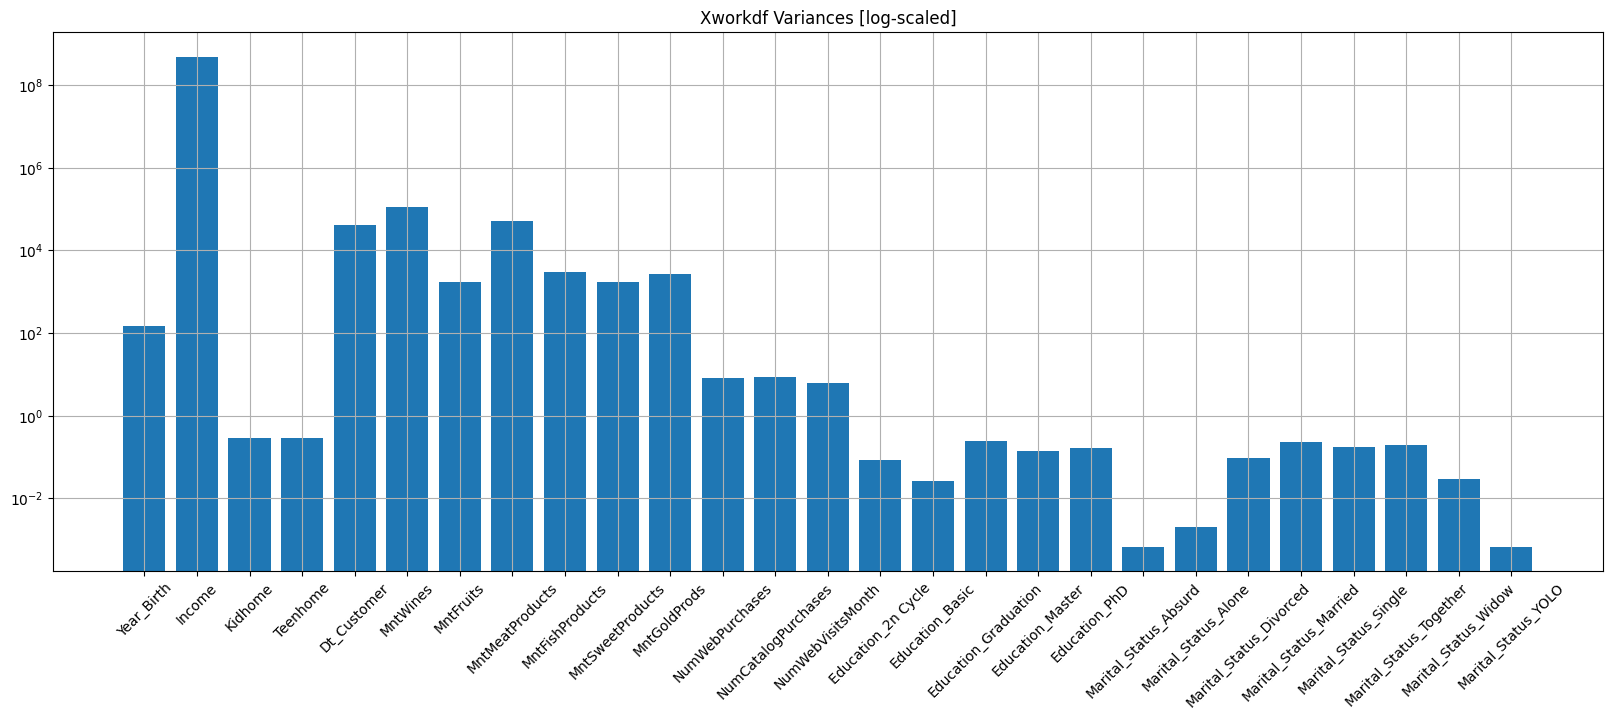

In [134]:
fig, ax = plt.subplots(figsize=(20, 7))

# Plotting the bar chart in the first subplot
ax.bar(np.arange(Xworkdf.shape[1]), np.array(Xworkdf.var()))
ax.set_xticks(ticks=np.arange(Xworkdf.shape[1]))
ax.set_xticklabels(labels=Xworkdf.columns.to_list(), rotation=45)
ax.set_title('Xworkdf Variances [log-scaled]')
ax.set_yscale('log')
ax.grid(visible=True, which='both')


### Xworkdf_std Variances Plot
The scaler standardize the data meaning all the data are re-centered and the standard deviation is normalized to 1, as can be seen in the graph of the Variance.

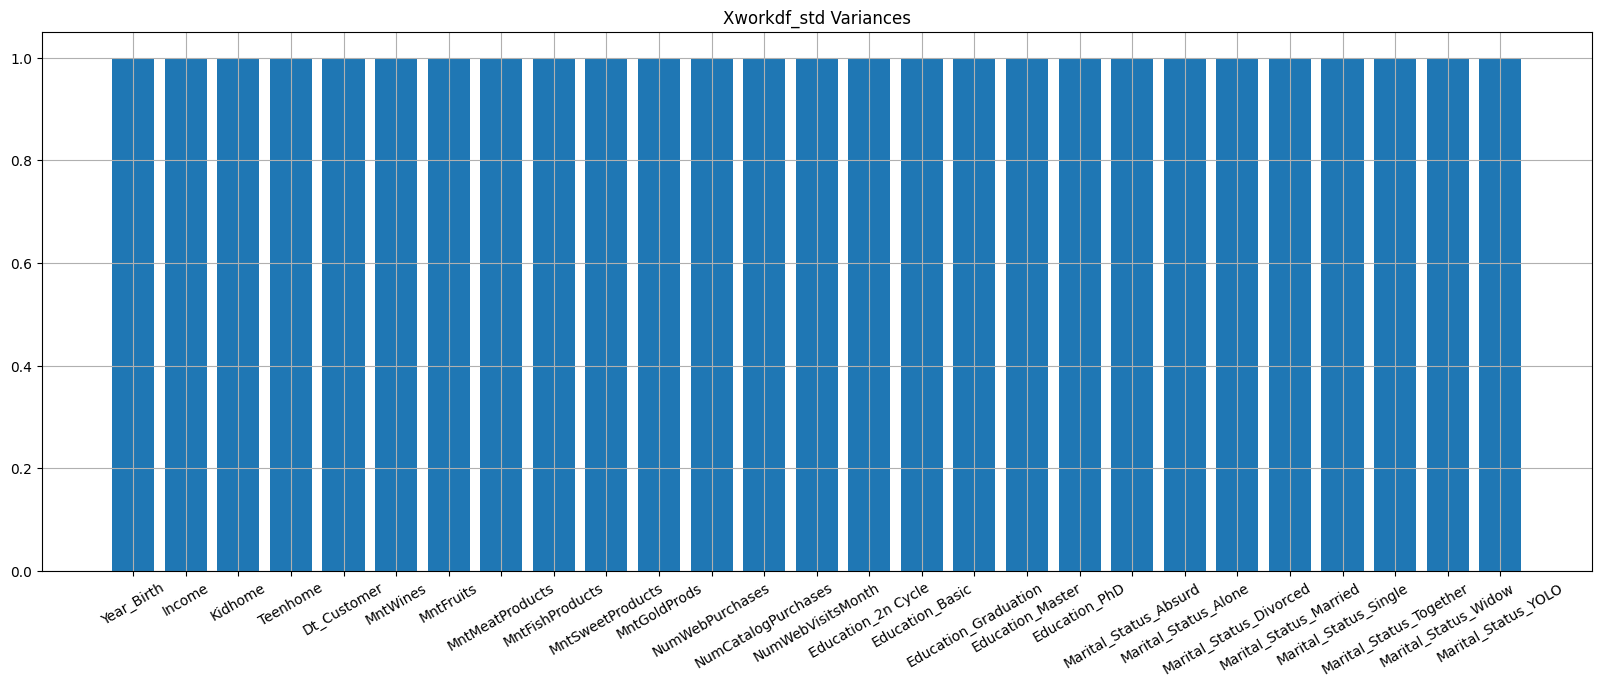

In [135]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.bar(np.arange(Xworkdf.shape[1]), Xworkdf_std.var())
ax.set_xticks(ticks=np.arange(Xworkdf.shape[1]), 
           labels=Xworkdf.columns.to_list(),
           rotation=30)
ax.set_title('Xworkdf_std Variances')
ax.grid(visible=True, which='both')

### Xworkdf_mm Variances Plot
Finally, the last graph illustrates the variances of the data after applying the MinMax scaler. This scaler transforms the data so that the values of each feature are distributed between 0 and 1.

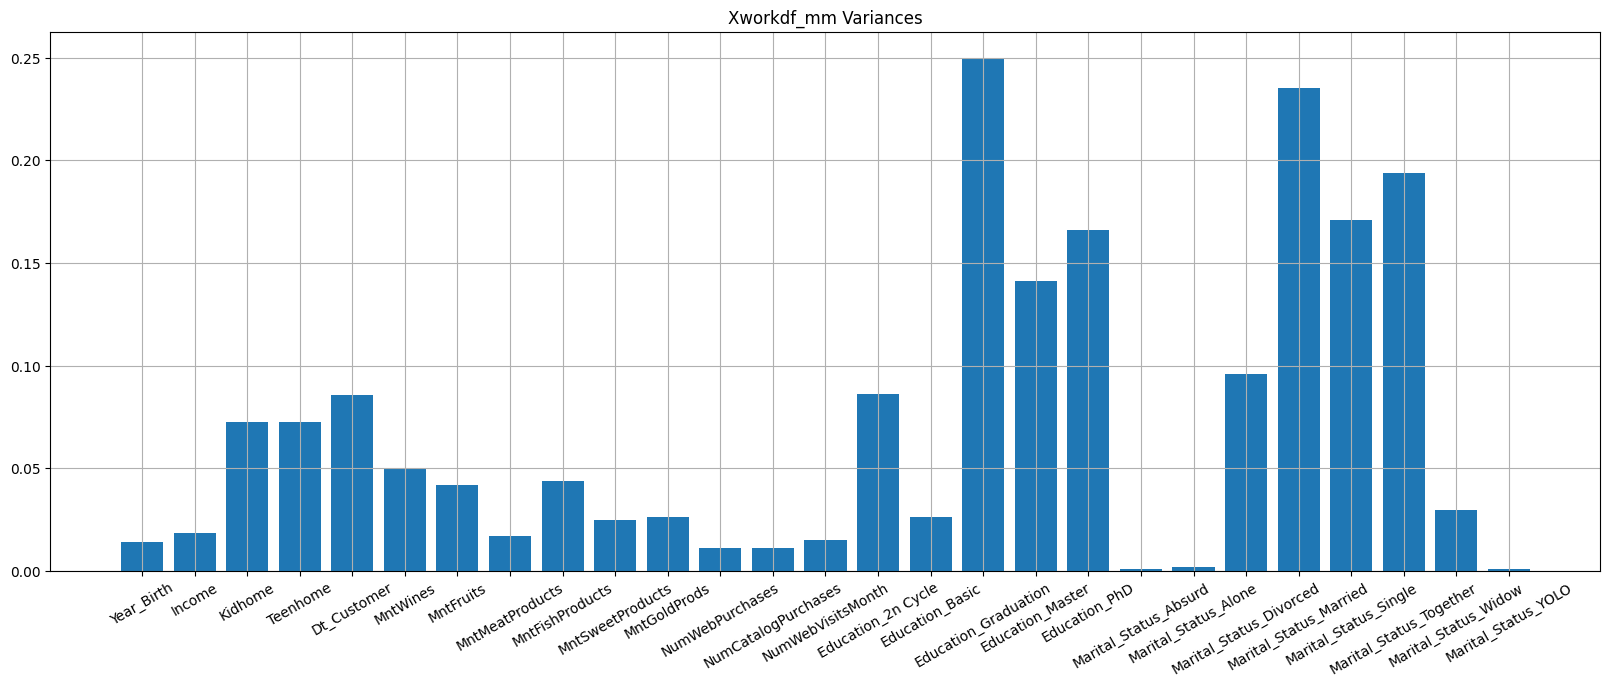

In [136]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.bar(np.arange(Xworkdf.shape[1]), Xworkdf_mm.var())
ax.set_xticks(ticks=np.arange(Xworkdf.shape[1]), 
           labels=Xworkdf.columns.to_list(),
           rotation=30)
ax.set_title('Xworkdf_mm Variances')
ax.grid(visible=True, which='both')

From the plots of these three graphs, it is clear that using a scaler is essential to highlight the importance of certain features that might be "covered" by others due to different units of measurement. For instance, notice how "Income" shows predominant variance in the first graph (without any scaler), while in the MinMax scaler plot, it assumes a significantly lower value compared to features like "Education" and "Marital_Status". These features would have been previously ignored in the PCA analysis without proper scaling. There isn't much to say about the Xworkdf_std graph since all the features have been standardized to have a variance of 1. If the features are uncorrelated, the principal components will be aligned with the original features, and fewer components might be needed to explain most of the variance in the dataset. However, if there are correlations among features, PCA will find new axes (principal components) that capture the most variance, and the weights of these components will vary based on how much variance they capture.

## 3.3 "full" PCA
As expected, the PCA explained variance graph for Xworkdf shows that the first principal component "eats" all the total variance. However, when using a scaler (as shown in the other two graphs), more principal components are needed to explain the total variance. Despite this, it is not necessary to use all the principal components to capture enough information to explain the entire dataset

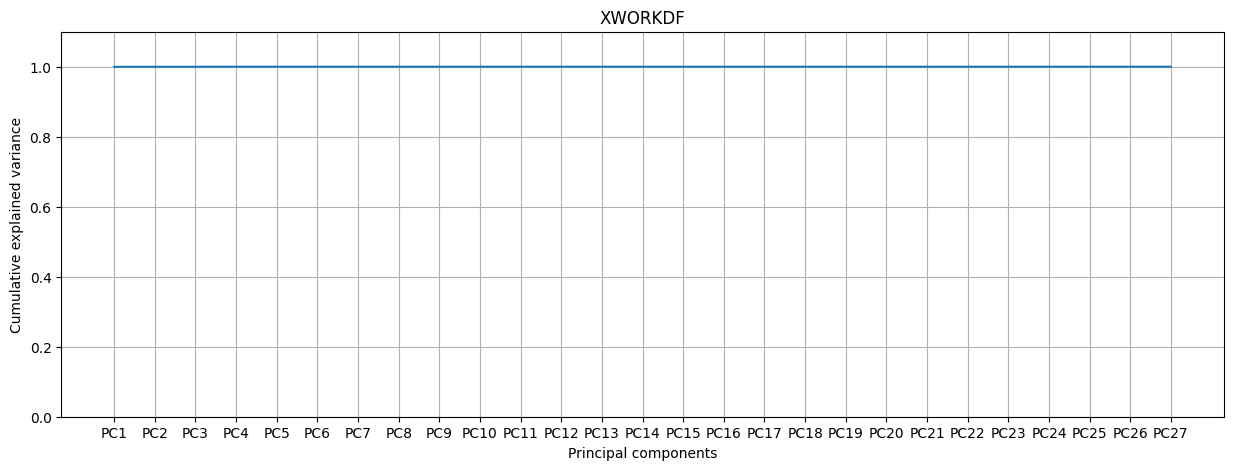

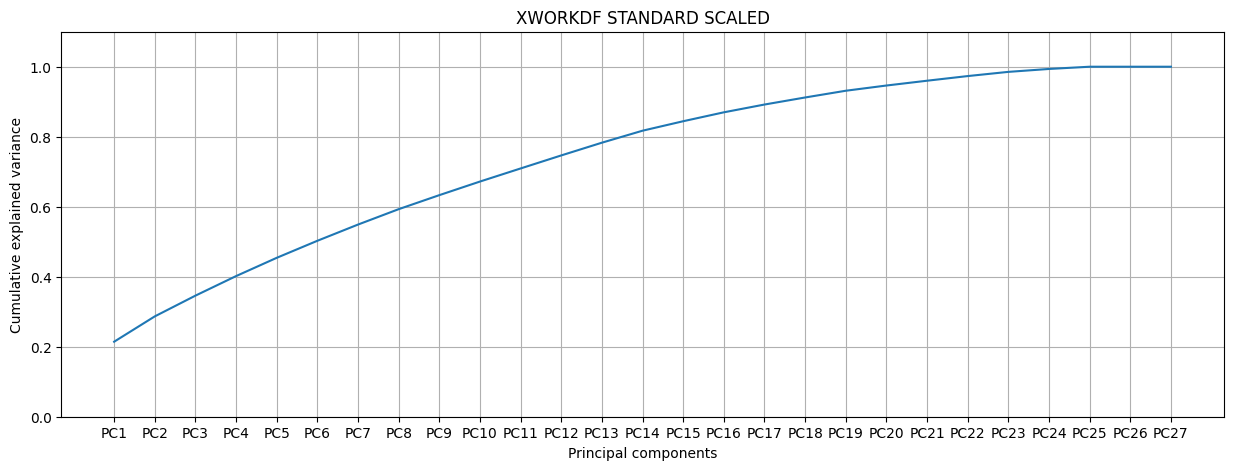

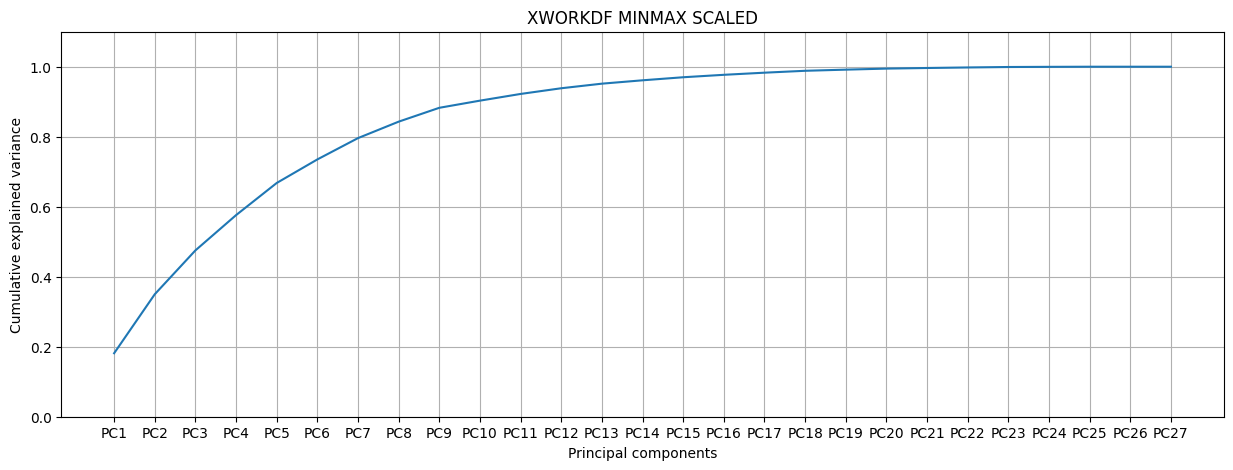

In [137]:
pca_nostd = PCA(random_state=rs)
pca_std = PCA(random_state=rs)
pca_mm = PCA(random_state=rs)

pca_nostd.fit(Xworkdf)
pca_std.fit(Xworkdf_std)
pca_mm.fit(Xworkdf_mm)

explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

#pca_nostd
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_nostd.explained_variance_ratio_))
plt.title('XWORKDF')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_nostd.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca_nostd.n_features_in_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


#pca_std
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_std.explained_variance_ratio_))
plt.title('XWORKDF STANDARD SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_std.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca_std.n_features_in_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

#pca_mm
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_mm.explained_variance_ratio_))
plt.title('XWORKDF MINMAX SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_mm.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca_mm.n_features_in_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


# 4. Dimensionality Reduction and Interpretation of the PCs
The value of m = min{m', 5} is computed and stored in the variables m_std and m_mm

In [138]:
m_prime_std = np.argmax(explained_variance_std > 0.33) + 1
m_prime_mm = np.argmax(explained_variance_mm > 0.33) + 1

m_std = min(m_prime_std, 5)
m_mm = min(m_prime_mm, 5)

print(f'm_std is equal to: {m_std}')
print(f'm_mm is equal to: {m_mm}')

pca_std = PCA(n_components=m_std, random_state = rs)
pca_mm = PCA(n_components=m_mm, random_state=rs)

Y_Xworkdf_std = pca_std.fit_transform(Xworkdf_std)
Y_Xworkdf_mm = pca_mm.fit_transform(Xworkdf_mm)


m_std is equal to: 3
m_mm is equal to: 2


The positive and negative influence of the features to each PC can be efficiently showed by using bar plots. Moreover, an heuristic method is used to assign meaningful names to the principal components, this is necessary because increasing the number of features makes the interpretation of the bar plots increasingly complex. 

For each principal component the only features that are considered are the ones that contribute more than an arbitrary threshold: $$\epsilon = \sqrt{\frac{1}{n}}$$ Specifically, for the naming, are used only those features whose absolute value exceeds $\epsilon$ for that PC. 

In the plot, features surpassing the thresholds are highlighted: orange for positive influence and blue for negative influence.


### Xworkdf_std Bar Plot
By looking at the bar plots, we can obtain some insigths on the relationship between the features:
- PC1: primarily seems to capture aspects related to purchasing behavior and income. Individuals with higher income tend to spend more on various products, whereas households with more children or higher web visits might spend less.

- PC2: appears to differentiate between higher education levels and age, with younger individuals and those with higher educational qualifications likely having different purchasing patterns or behaviors.

- PC3: may capture the contrast between higher educational qualifications and recency of customer acquisition against other variables like number of children and web purchase behaviors.

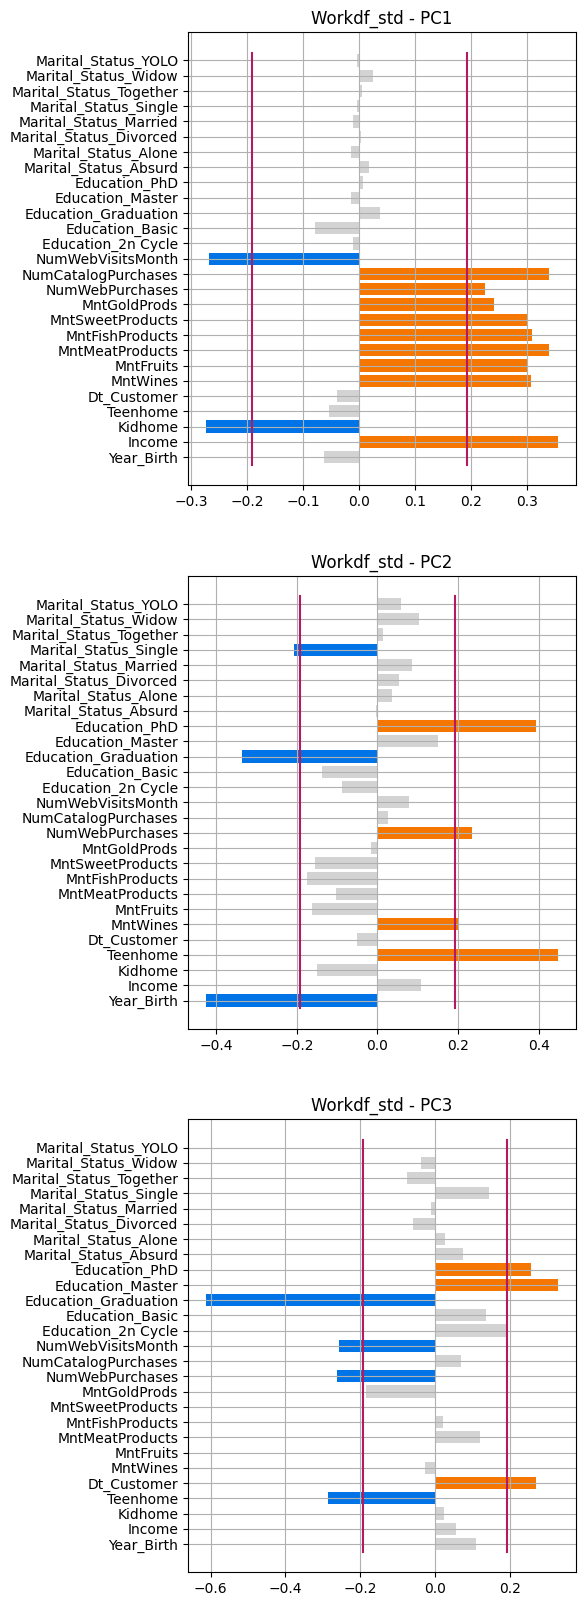

In [139]:
eps = np.sqrt(1 / Xworkdf.shape[1])

fig, ax = plt.subplots(m_std, 1, figsize=(5, 20))
num = 0
for i in range(0, m_std):
        ax[i].plot([eps, eps], [-0.5, pca_std.n_features_in_ - 0.5], '#b51963')
        ax[i].plot([-eps, -eps], [-0.5, pca_std.n_features_in_ - 0.5],'#b51963')
        color_list = ['#F57600' if val >= eps else '#0073E6' if val <= -eps else '#D3D3D3' for val in pca_std.components_[i, :]]
        ax[i].barh(np.arange(pca_std.n_features_in_), pca_std.components_[i, :], color=color_list)
        ax[i].set_yticks(ticks=np.arange(pca_std.n_features_in_))
        ax[i].set_yticklabels(labels=Xworkdf_std.columns.to_list())
        ax[i].set_title('Workdf_std - PC%d' % (i+1))
        ax[i].grid()



### Xworkdf_mm Bar Plot
By looking at the bar plots, we can obtain some insigths on the relationship between the features:
- PC1: The positive contributions of Education_PhD and Education_Master alongside Marital_Status_Married suggest that individuals with higher levels of education (PhD, Master's) are more likely to be married. This aligns with some real-world data, where higher education often comes with greater economic stability, which can support the social and financial commitments of marriage.

- PC2: differentiate between different marital statuses, especially contrasting Married status with Single and Together statuses.

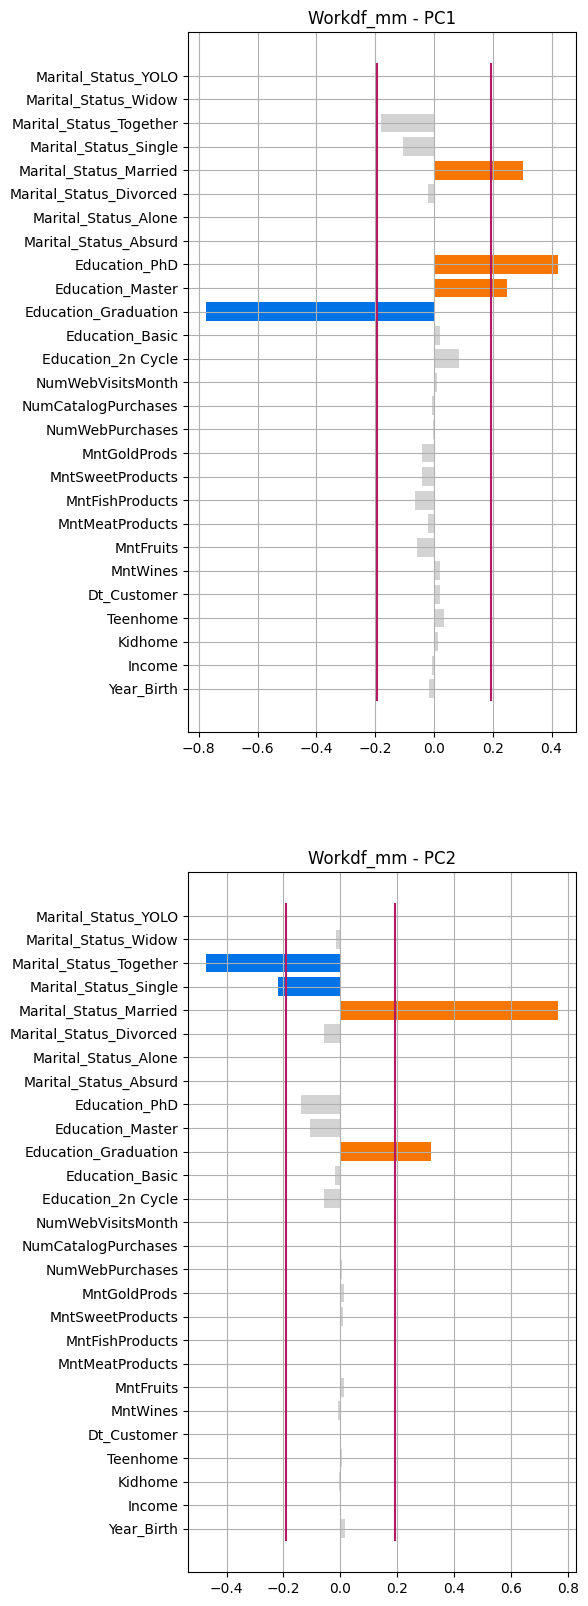

In [140]:
eps = np.sqrt(1 / Xworkdf.shape[1])

fig, ax = plt.subplots(m_mm, 1, figsize=(5, 20))
for i in range(0, m_mm):
        ax[i].plot([eps, eps], [-0.5, pca_mm.n_features_in_ - 0.5], '#b51963')
        ax[i].plot([-eps, -eps], [-0.5, pca_mm.n_features_in_ - 0.5],'#b51963')
        color_list = ['#F57600' if val >= eps else '#0073E6' if val <= -eps else '#D3D3D3' for val in pca_mm.components_[i, :]]
        ax[i].barh(np.arange(pca_mm.n_features_in_), pca_mm.components_[i, :], color=color_list)
        ax[i].set_yticks(ticks=np.arange(pca_mm.n_features_in_))
        ax[i].set_yticklabels(labels=Xworkdf_mm.columns.to_list())
        ax[i].set_title('Workdf_mm - PC%d' % (i+1))
        ax[i].grid()

plt.show()

## 4.1 PC names
Based on which features surpassed the treshold the name were decided as follows:
### Xwordf_std Names
PC1 : Customer's Income & Purchases (+) VS Montly Web Visits of a Customer with Kids (-)

PC2 : Customer with PHD & Teens that prefer Online Shopping Of Wine (+) VS 

$\hspace{1cm}$ Age Verified Customer with Graduation that is Single (-) 
PC3: Date of the Website Sign Up of a Customer with either a Master or a PHD (+) VS
    Monthly Web Visits of a Customer with Graduation and Kids that prefer Online Shopping(-) 

### Xwordf_mm Names

In [141]:
#PC1 : Customer's Income & Purchases (+) VS 
#   Montly Web Visits of a Customer with Kids (-)
stdPC1 = "C.Inc_Purc_vs\n_MwV_C.K"    

#PC2: Customer with PHD & Teens that prefer Online Shopping Of Wine (+) VS 
#   Age Verified Customer with Graduation that is Single (-) 
stdPC2 = "C.PhD_T_OnShopWine_vs\n_AvC.Grad_Single" 

#PC3: Date of the Website Sign Up of a Customer with either a Master or a PHD (+) VS
#   Monthly Web Visits of a Customer with Graduation and Kids that prefer Online Shopping(-) 
stdPC3 = "DwSu_C.Master/PhD_vs\n_MwV_C.Grad_K_OnShop" 


#PC1 : A Customer with either a Master or a PHD that is Married (+) VS A Graduated customer (-)
mmPC1 = "C.Master/PhD_Married_vs\n_C.Grad"  
#PC2: A Customer with Graduation that is Married (+) VS A customer either Single or that Live Together(-)
mmPC2 = "C.Grad_Married_vs\n_C.Single/LivTog"  


## 4.2 Score Graph
The value of $\mathcal{l}$ is computed and stored in the variables m_std and m_mm

In [142]:
l_std = 2 if m_std == 2 else 3
l_mm = 2 if m_mm == 2 else 3

print(f'l_std is equal to: {l_std}')
print(f'l_mm is equal to: {l_mm}')

l_std is equal to: 3
l_mm is equal to: 2


## Xworkdf_std - Score Graph
The points are relatively spread out but form a loose cluster around the center, indicating that the data has been standardized to have a mean of zero and unit variance

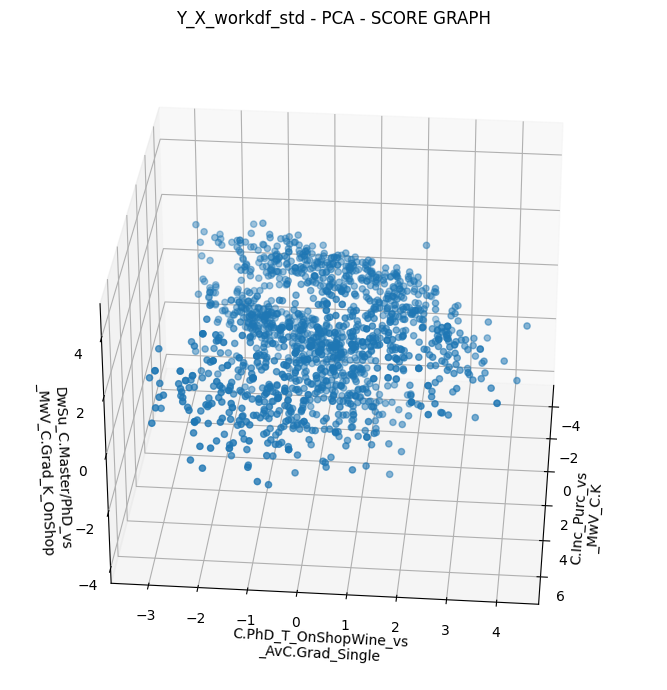

In [143]:
fig = plt.figure(figsize=(20,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2])
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.tight_layout()

## Xworkdf_mm - Score Graph
The points are distributed along discrete levels, indicating that min-max scaling has compressed the feature values into a fixed range. The 2D plot shows distinct clusters, highlighting natural groupings in the data.

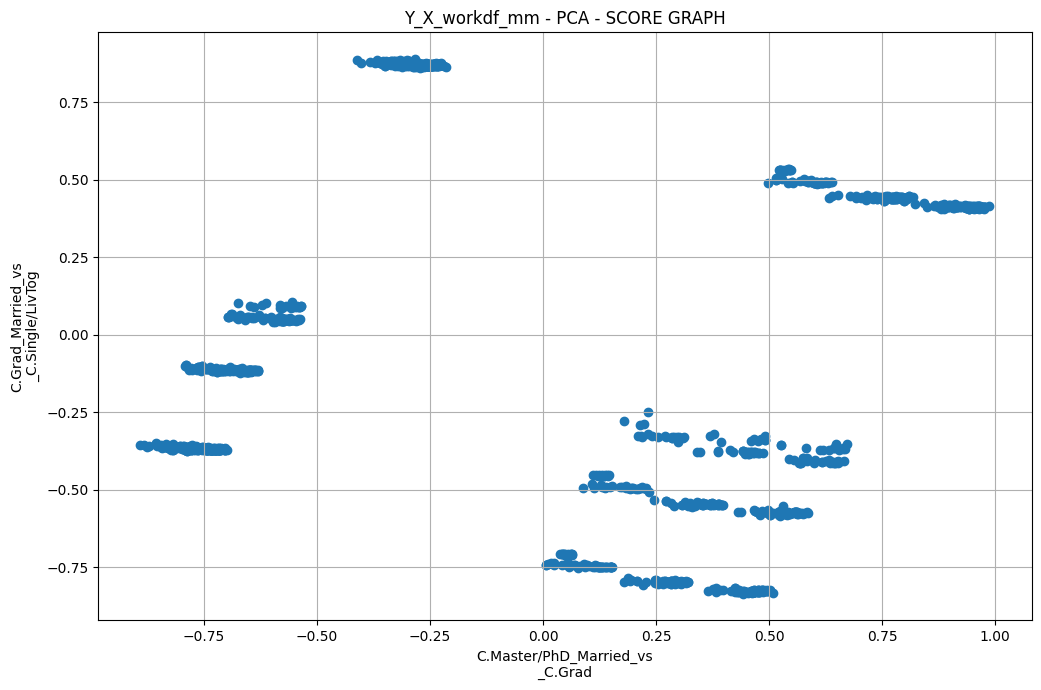

In [144]:
fig = plt.figure(figsize=(20,7)) 
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(Y_Xworkdf_mm[:, 0], Y_Xworkdf_mm[:, 1])
plt.title('Y_X_workdf_mm - PCA - SCORE GRAPH')
ax2.set_xlabel(f'{mmPC1}')
ax2.set_ylabel(f'{mmPC2}') 
plt.grid()
plt.tight_layout()
plt.show()

OPTIONAL: Confronto tra colonna response e Cmp = somma delle colonne 

In [145]:
Cmp_column = workdf['AcceptedCmp1'] + workdf['AcceptedCmp2'] + workdf['AcceptedCmp3'] + workdf['AcceptedCmp4'] + workdf['AcceptedCmp5'] + workdf['Response']
workdf['Cmp'] = Cmp_column
Cmp = np.sort(Cmp_column.unique())
Response = workdf['Response'].unique()
Complain = workdf['Complain'].unique()
# fai un print piu carino
display(Complain)

array([0, 1], dtype=int64)

OPTIANAL: Confronto tra le varie Campagne Pubblicitarie

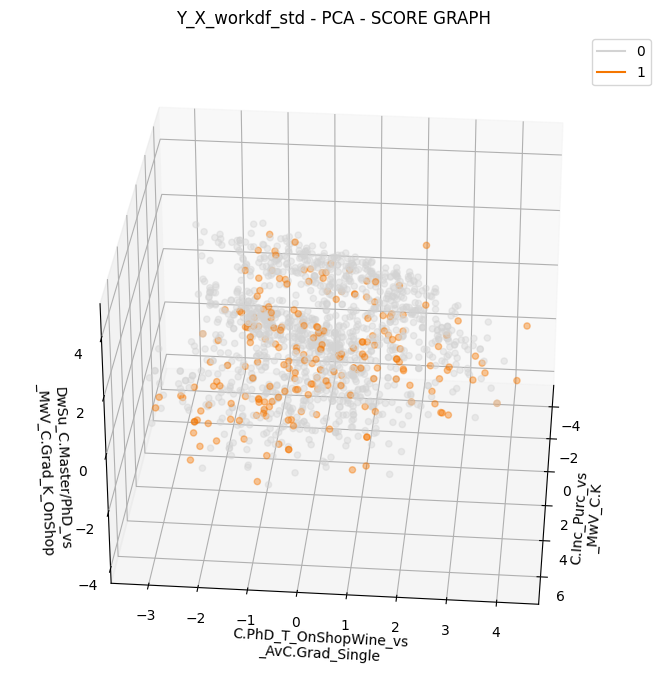

In [146]:
plt.close()
custom_colors_Response = ['#D3D3D3', '#F57600']

Response_colors = {Response[i]: custom_colors_Response[i] for i in range(len(Response))} 
workdf['color_Response'] = [Response_colors[t] for t in workdf['Response'].values]
Reponse_color_legend = [Line2D([0], [0], color=Response_colors[k]) for k in Response_colors.keys()]

fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
scatter = ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Response'].values, alpha = 0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.legend(Reponse_color_legend, [k for k in Response_colors.keys()])  
plt.tight_layout()

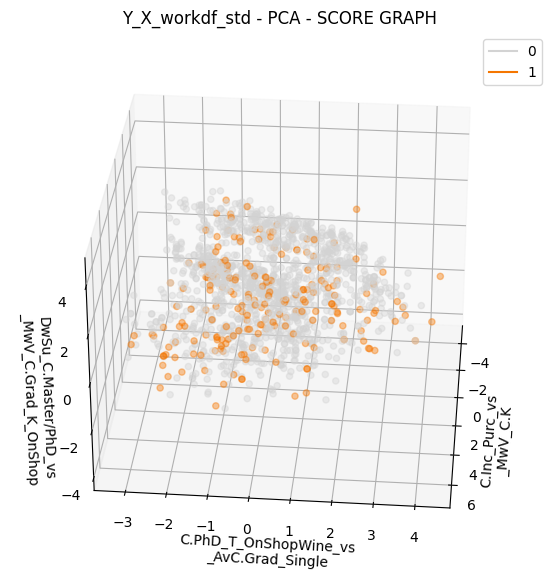

In [147]:
Response_colors = {Response[i]: custom_colors_Response[i] for i in range(len(Response))} 
workdf['color_Response'] = [Response_colors[t] for t in workdf['Response'].values]
Reponse_color_legend = [Line2D([0], [0], color=Response_colors[k]) for k in Response_colors.keys()]

fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Response'].values, alpha = 0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.legend(Reponse_color_legend, [k for k in Response_colors.keys()])   


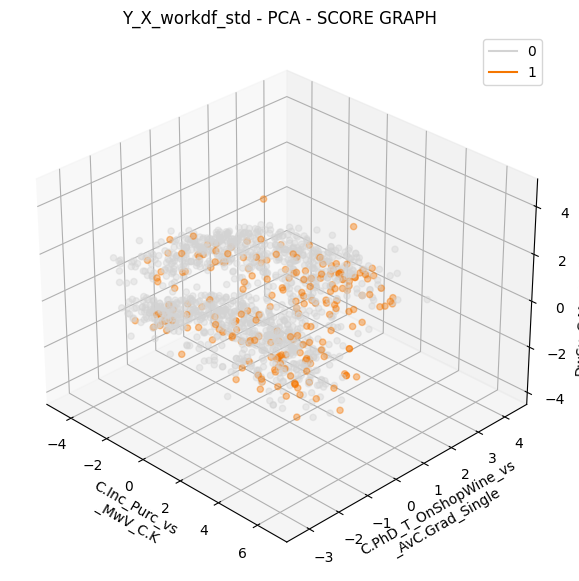

In [148]:
plt.close()
custom_colors_Response = ['#D3D3D3', '#F57600']

Response_colors = {Response[i]: custom_colors_Response[i] for i in range(len(Response))} 
workdf['color_Response'] = [Response_colors[t] for t in workdf['Response'].values]
Reponse_color_legend = [Line2D([0], [0], color=Response_colors[k]) for k in Response_colors.keys()]

fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Response'].values, alpha=0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=-45)
plt.legend(Reponse_color_legend, [k for k in Response_colors.keys()])   

Commenta i displays

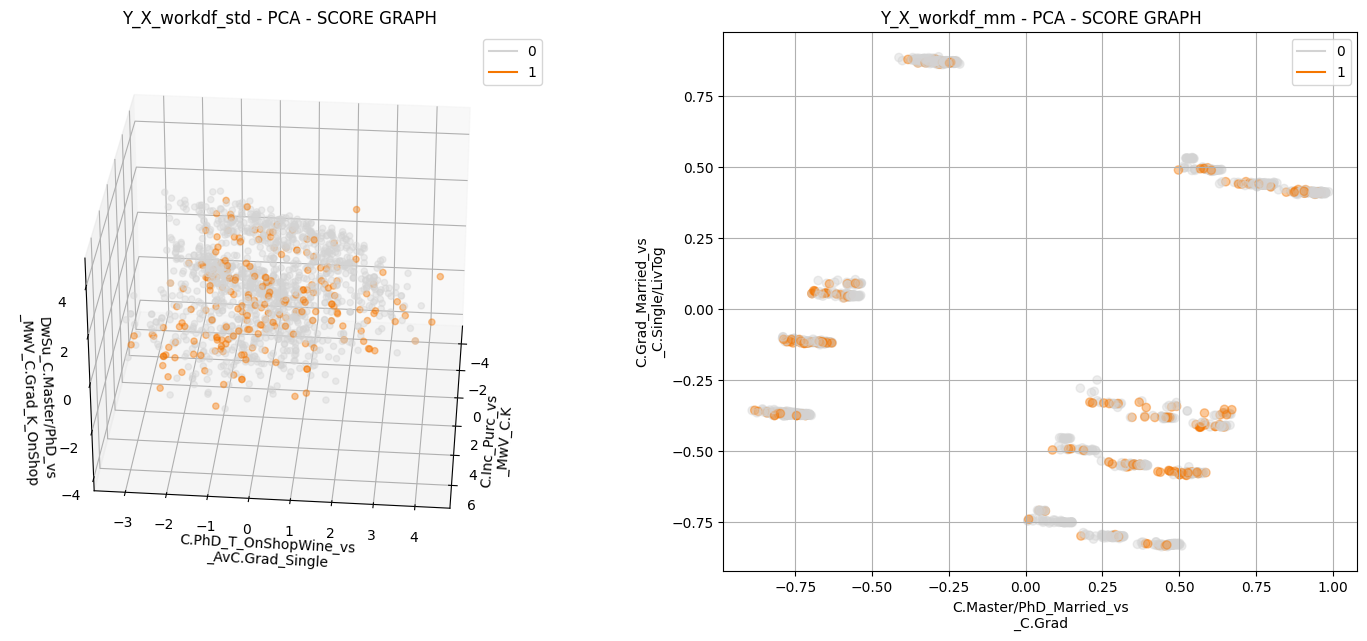

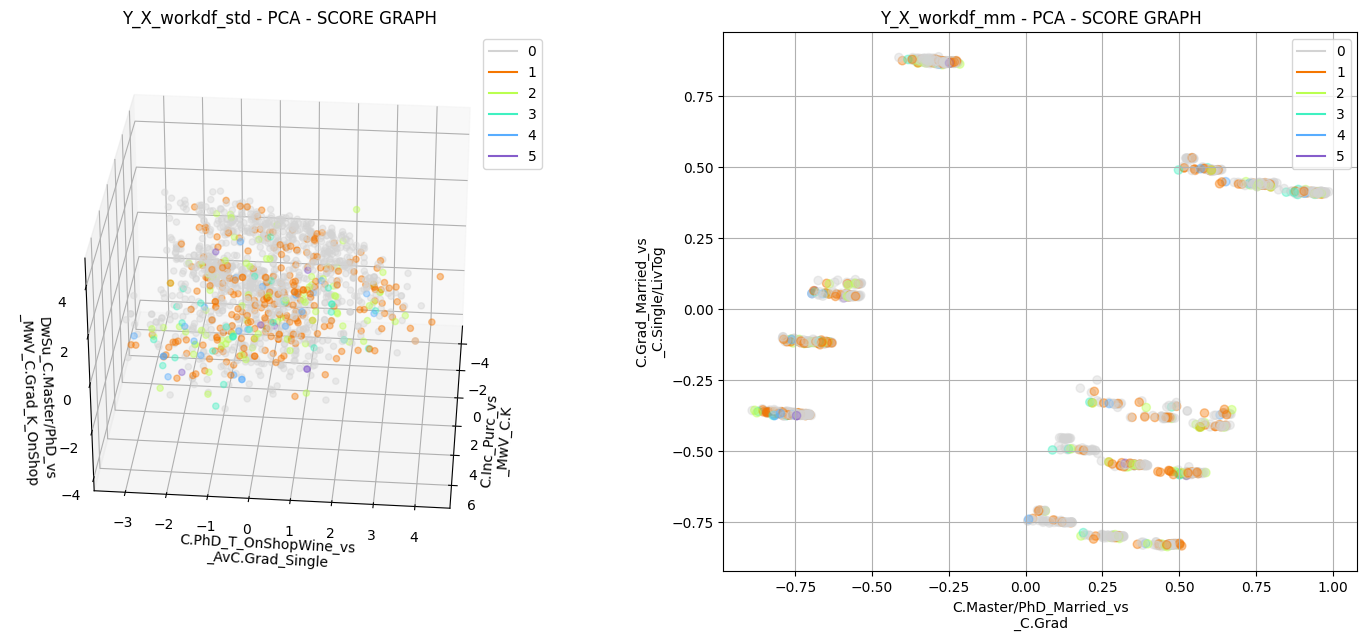

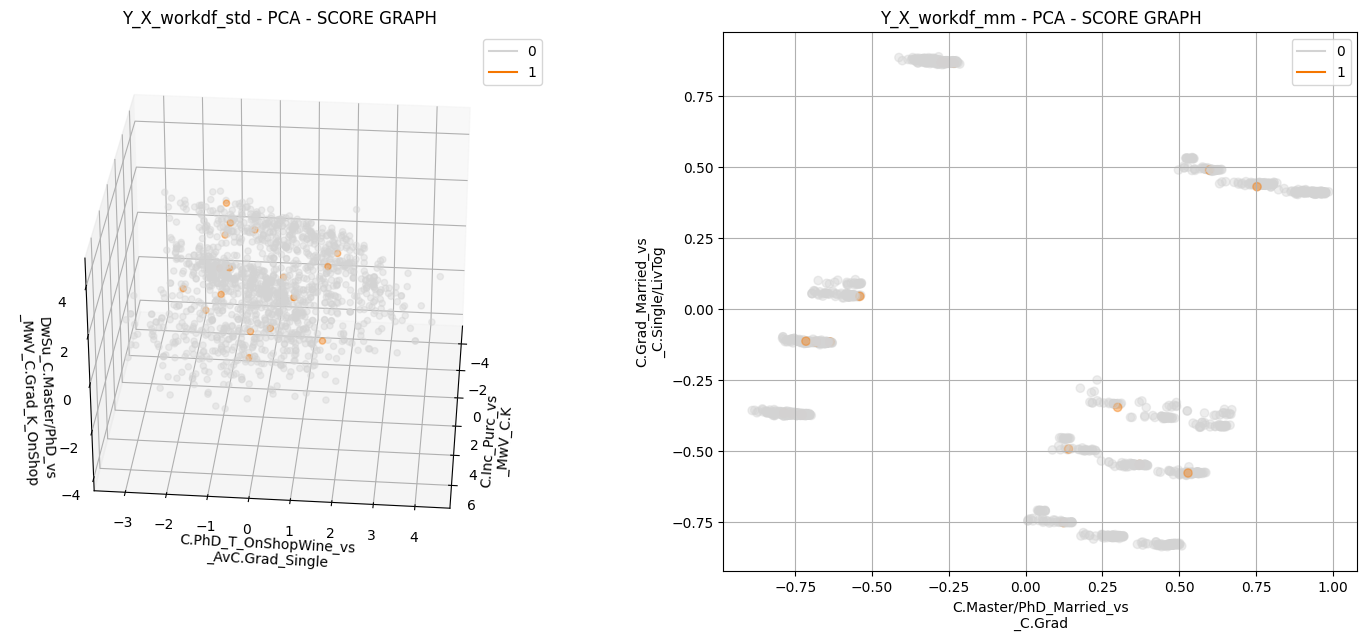

In [149]:
plt.close()
custom_colors_Response = ['#D3D3D3', '#F57600']

Response_colors = {Response[i]: custom_colors_Response[i] for i in range(len(Response))} 
workdf['color_Response'] = [Response_colors[t] for t in workdf['Response'].values]
Reponse_color_legend = [Line2D([0], [0], color=Response_colors[k]) for k in Response_colors.keys()]


fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Response'].values, alpha = 0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.legend(Reponse_color_legend, [k for k in Response_colors.keys()])   



ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(Y_Xworkdf_mm[:, 0], Y_Xworkdf_mm[:, 1], c=workdf['color_Response'].values, alpha = 0.4)
plt.title('Y_X_workdf_mm - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{mmPC1}')
ax1.set_ylabel(f'{mmPC2}') 
plt.legend(Reponse_color_legend, [k for k in Response_colors.keys()])
plt.grid()
plt.show()


custom_colors_Cmp = ['#D3D3D3', '#F57600', '#baff4f', '#3ff1c1', '#58adff', '#865dcb']
Cmp_colors = {Cmp[i]: custom_colors_Cmp[i] for i in range(len(Cmp))} 
workdf['color_Cmp'] = [Cmp_colors[t] for t in Cmp_column.values]
Cmp_color_legend = [Line2D([0], [0], color=Cmp_colors[k]) for k in Cmp_colors.keys()]


fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Cmp'].values, alpha = 0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.legend(Cmp_color_legend, [k for k in Cmp_colors.keys()])               



ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(Y_Xworkdf_mm[:, 0], Y_Xworkdf_mm[:, 1], c=workdf['color_Cmp'].values, alpha = 0.4)
plt.title('Y_X_workdf_mm - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{mmPC1}')
ax1.set_ylabel(f'{mmPC2}') 
plt.legend(Cmp_color_legend, [k for k in Cmp_colors.keys()])


plt.grid()
plt.show()

custom_colors_Complain = ['#D3D3D3', '#F57600']
Complain_colors = {Complain[i]: custom_colors_Complain[i] for i in range(len(Complain))} 
workdf['color_Complain'] = [Complain_colors[t] for t in workdf['Complain'].values]
Complain_color_legend = [Line2D([0], [0], color=Complain_colors[k]) for k in Complain_colors.keys()]

fig = plt.figure(figsize=(18,7)) 
ax1 = fig.add_subplot(1, 2, 1, projection=f'{l_std}d')
ax1.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['color_Complain'].values, alpha = 0.4)
plt.title('Y_X_workdf_std - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{stdPC1}')
ax1.set_ylabel(f'{stdPC2}') 
ax1.set_zlabel(f'{stdPC3}')
ax1.view_init(elev=30, azim=5)
plt.legend(Complain_color_legend, [k for k in Complain_colors.keys()])               



ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(Y_Xworkdf_mm[:, 0], Y_Xworkdf_mm[:, 1], c=workdf['color_Complain'].values, alpha = 0.4)
plt.title('Y_X_workdf_mm - PCA - SCORE GRAPH')
ax1.set_xlabel(f'{mmPC1}')
ax1.set_ylabel(f'{mmPC2}') 

plt.legend(Complain_color_legend, [k for k in Complain_colors.keys()])

plt.grid()
plt.show()

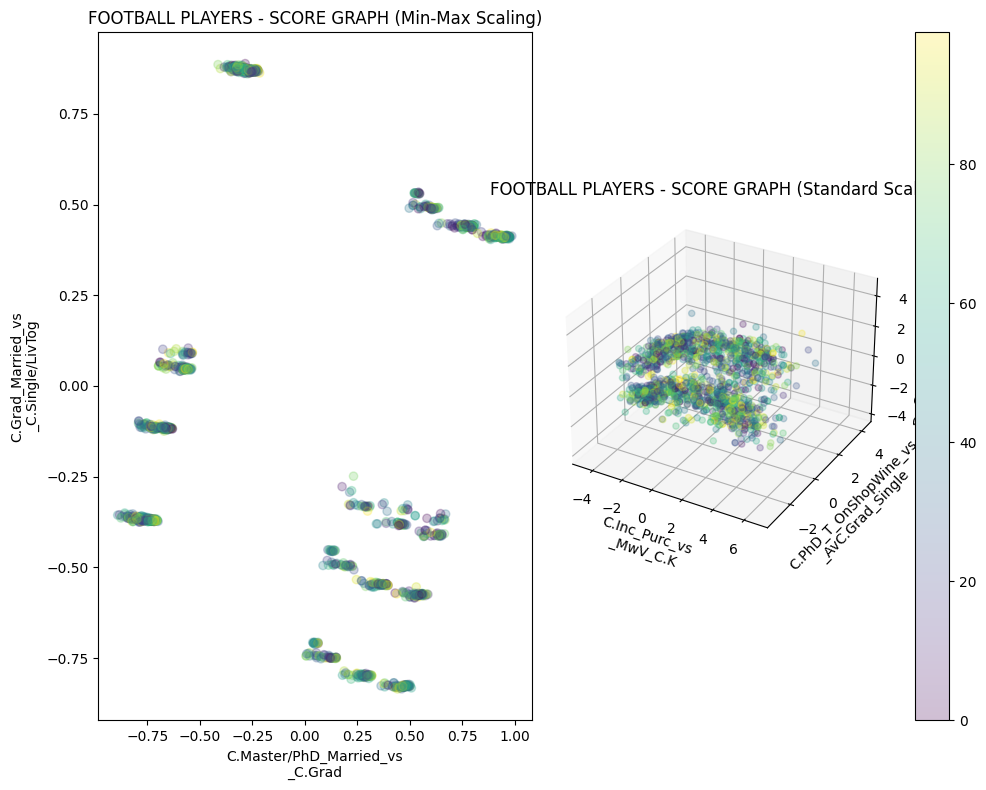

In [150]:
# MAKE THE 3D SCORE GRAPH
fig_recency = plt.figure(figsize=(10, 8))

# First subplot
ax_recency1 = fig_recency.add_subplot(121)
scatter1 = ax_recency1.scatter(Y_Xworkdf_mm[:, 0], Y_Xworkdf_mm[:, 1], c=workdf['Recency'].values, alpha=0.25)
ax_recency1.set_title('FOOTBALL PLAYERS - SCORE GRAPH (Min-Max Scaling)')
ax_recency1.set_xlabel(f'{mmPC1}')
ax_recency1.set_ylabel(f'{mmPC2}')

# Second subplot

ax_recency2 = fig_recency.add_subplot(122, projection='3d')
scatter2 = ax_recency2.scatter(Y_Xworkdf_std[:, 0], Y_Xworkdf_std[:, 1], Y_Xworkdf_std[:, 2], c=workdf['Recency'].values, alpha=0.25)
ax_recency2.set_title('FOOTBALL PLAYERS - SCORE GRAPH (Standard Scaling)')
ax_recency2.set_xlabel(f'{stdPC1}')
ax_recency2.set_ylabel(f'{stdPC2}')
ax_recency2.set_zlabel(f'{stdPC3}')

# Adjust layout
fig_recency.tight_layout()

# Add colorbar
cbar = fig_recency.colorbar(scatter2)

# Show the plot
plt.grid()
plt.show()

## 5. k-Means
The $k$-Means algorithm is executed for each value $k\in\{3,...,10\}$, so that the optimal value can determined, by selecting the one that maximizes the average *silhouette coefficient*.

In [151]:
k_list = [i for i in range(3, 11)]
km_list_std = []
km_list_mm = []
silcoeff_list_std = []
silcoeff_list_mm = []

for i in range(len(k_list)):
    km_list_std.append(KMeans(n_clusters=k_list[i], n_init="auto", random_state=rs))
    km_list_mm.append(KMeans(n_clusters=k_list[i], n_init="auto", random_state=rs))
    cluster_labels_std = km_list_std[i].fit_predict(Y_Xworkdf_std[:,0:l_std])
    cluster_labels_mm = km_list_mm[i].fit_predict(Y_Xworkdf_mm)
    silhouette_avg_std = silhouette_score(Y_Xworkdf_std, cluster_labels_std)
    silhouette_avg_mm = silhouette_score(Y_Xworkdf_mm, cluster_labels_mm)
    silcoeff_list_std.append(silhouette_avg_std)
    silcoeff_list_mm.append(silhouette_avg_mm)

    print(
        "For n_clusters =",
        k_list[i],
        "\n - silhouette_score_std is:\t",
        silhouette_avg_std,
        "\n - silhouette_score_mm is:\t",
        silhouette_avg_mm
    )
    
best_k_std = k_list[np.argmax(silcoeff_list_std)]
best_k_mm = k_list[np.argmax(silcoeff_list_mm)]
km_std = km_list_std[np.argmax(silcoeff_list_std)]
km_mm = km_list_mm[np.argmax(silcoeff_list_mm)]
    
print(f'\n\nBest silhouette_score_std:\t{np.max(silcoeff_list_std):.5f} => n_cluster= {best_k_std}') 
print(f'Best silhouette_score_mm:\t{np.max(silcoeff_list_mm):.5f} => n_cluster= {best_k_mm}')   

For n_clusters = 3 
 - silhouette_score_std is:	 0.34570354637480233 
 - silhouette_score_mm is:	 0.6496596420594638
For n_clusters = 4 
 - silhouette_score_std is:	 0.3239733998518198 
 - silhouette_score_mm is:	 0.804948058973445
For n_clusters = 5 
 - silhouette_score_std is:	 0.32577792069282513 
 - silhouette_score_mm is:	 0.7833466588458111
For n_clusters = 6 
 - silhouette_score_std is:	 0.34086883770177867 
 - silhouette_score_mm is:	 0.70090658252506
For n_clusters = 7 
 - silhouette_score_std is:	 0.3336230347291751 
 - silhouette_score_mm is:	 0.7178347217389738
For n_clusters = 8 
 - silhouette_score_std is:	 0.3244855226623685 
 - silhouette_score_mm is:	 0.6959477398856098
For n_clusters = 9 
 - silhouette_score_std is:	 0.3358846735196086 
 - silhouette_score_mm is:	 0.700989585163108
For n_clusters = 10 
 - silhouette_score_std is:	 0.3285327257260854 
 - silhouette_score_mm is:	 0.7233774997296311


Best silhouette_score_std:	0.34570 => n_cluster= 3
Best silhouette_sco

# 6. Clusters and Centroid Interpretation and Visualization
Barplots of the PC-coordinates of the centroids are printed, so that is possible to assign names or brief descriptions to the clusters corresponding to the centroids.

### Xworkdf_std Centroids - Bar Plot
By looking at the centroids coordinates we can assign a proper naming to the clusters
- Cluster 1: "Customers with many Kids,that check the WebSite regularly"

- Cluster 2: "Customers with many Teens that Mainly have a PHD and Shop Wine on the WebSite"

- Cluster 3: "Rich Customers that shop a lot"

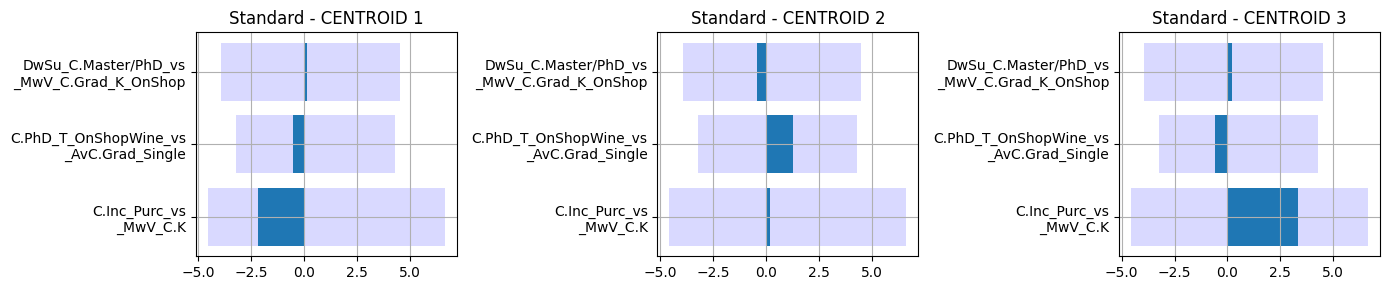

In [152]:
maxs_std = Y_Xworkdf_std[:, 0:l_std].max(axis=0) 
mins_std = Y_Xworkdf_std[:, 0:l_std].min(axis=0) 

fig_std, ax_std = plt.subplots(1, 3, figsize=(14, 3))
for ii in range(3):
    ax_std[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), maxs_std, color='blue', alpha=0.15)
    ax_std[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), mins_std, color='blue', alpha=0.15)
    ax_std[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii, :])
    ax_std[ii].set_yticks(ticks=np.arange(km_std.cluster_centers_.shape[1]))
    ax_std[ii].set_yticklabels(labels=[stdPC1, stdPC2, stdPC3], rotation=0)  # Note the rotation value
    ax_std[ii].grid(visible=True, which='both')
    ax_std[ii].set_title(f'Standard - CENTROID {ii+1}')
fig_std.tight_layout()

### Xworkdf_std Centroids - Bar Plot
By looking at the centroids coordinates we can assign a proper naming to the clusters
- Cluster 1: "Customers with different Education Backgrounds that are Married"

- Cluster 2: "Customers with Graduation that are Not Married"

- Cluster 3: "Customers with higher levels of Education that have Eterogenous Marital Status"

- Cluster 4: "Customers with Graduation that are Married"

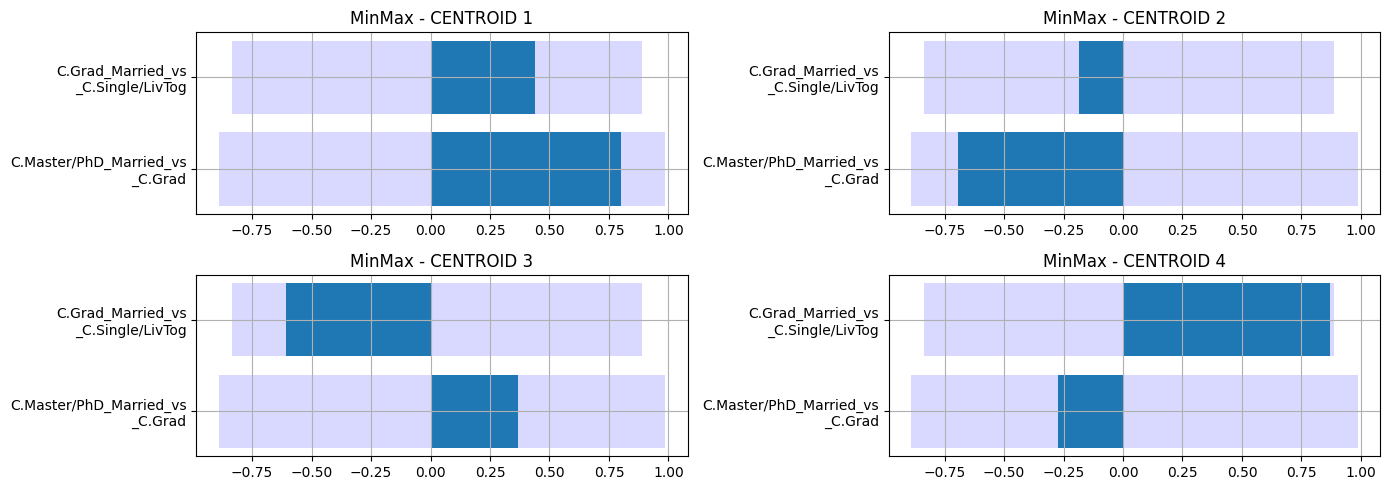

In [153]:

maxs_mm = Y_Xworkdf_mm.max(axis=0) 
mins_mm = Y_Xworkdf_mm.min(axis=0) 


fig_mm, ax_mm = plt.subplots(2, 2, figsize=(14, 5))
num = 0
for ii in range(2):
    for jj in range(2):
        ax_mm[ii,jj].barh(np.arange(km_mm.cluster_centers_.shape[1]), maxs_mm, color='blue', alpha=0.15)
        ax_mm[ii,jj].barh(np.arange(km_mm.cluster_centers_.shape[1]), mins_mm, color='blue', alpha=0.15)
        ax_mm[ii,jj].barh(np.arange(km_mm.cluster_centers_.shape[1]), km_mm.cluster_centers_[num, :])
        ax_mm[ii,jj].set_yticks(ticks=np.arange(km_mm.cluster_centers_.shape[1]))
        ax_mm[ii,jj].set_yticklabels(labels=[mmPC1, mmPC2], rotation=0)
        ax_mm[ii,jj].grid(visible=True, which='both')
        ax_mm[ii,jj].set_title(f'MinMax - CENTROID {num+1}')
        num += 1
fig_mm.tight_layout()

In [154]:
cluster_names_std = ['Customers with many Kids,that check the WebSite regularly',
                     'Customers with many Children that Mainly have a PHD and Shop Wine on the WebSite',
                     'Rich Customers that shop a lot'

]

In [155]:
cluster_names_mm = ["Customers with different Education Backgrounds that are Married",
                    "Customers with Graduation that are Not Married",
                    "Customers with higher levels of Education that have Eterogenous Marital Status",
                    "Customers with Graduation that are Married",
]

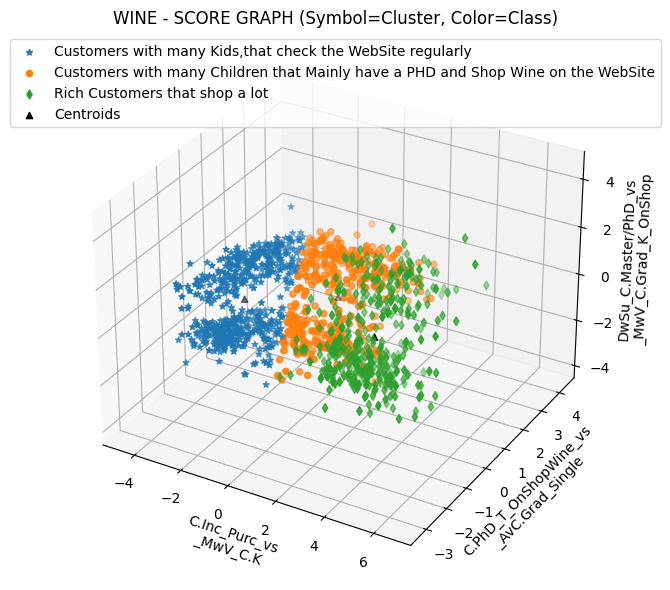

In [234]:
markers_dict_std = {0: '*', 1: 'o', 2: 'd'}

# Plotting the first graph with 3D projection
fig_stdscore = plt.figure(figsize=(20, 6))  # Increased size
ax = fig_stdscore.add_subplot(111, projection='3d')
for ll in np.unique(km_std.labels_):
    ax.scatter(Y_Xworkdf_std[km_std.labels_ == ll, 0], Y_Xworkdf_std[km_std.labels_ == ll, 1], Y_Xworkdf_std[km_std.labels_ == ll, 2], marker=markers_dict_std[ll], label=cluster_names_std[ll])
ax.scatter(km_std.cluster_centers_[:, 0], km_std.cluster_centers_[:, 1], km_std.cluster_centers_[:, 2], c='black', marker='^', label='Centroids')
plt.title('WINE - SCORE GRAPH (Symbol=Cluster, Color=Class)')
ax.set_xlabel(f'{stdPC1}')
ax.set_ylabel(f'{stdPC2}') 
ax.set_zlabel(f'{stdPC3}')
ax.legend(loc='upper center')
fig_stdscore.tight_layout()
plt.grid()
plt.show()


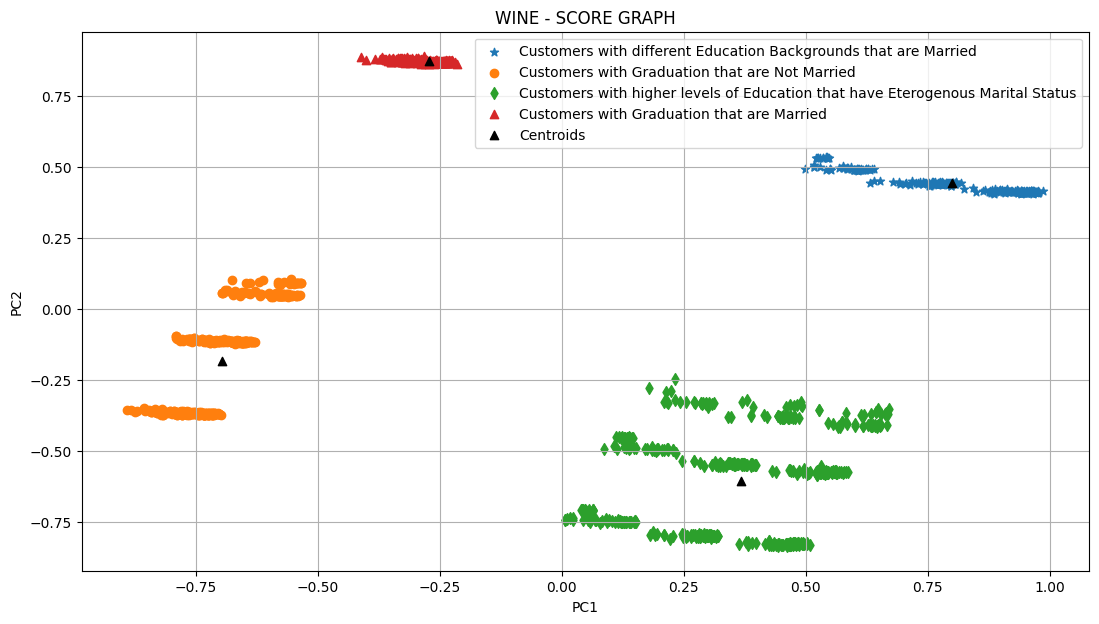

In [239]:

# Plotting the second graph
fig_stdscore = plt.figure(figsize=(13, 7))
ax = fig_stdscore.add_subplot(111)
for ll in np.unique(km_mm.labels_):
    ax.scatter(Y_Xworkdf_mm[km_mm.labels_ == ll, 0], Y_Xworkdf_mm[km_mm.labels_ == ll, 1], marker=markers_dict_mm[ll], label=cluster_names_mm[ll])
ax.scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], c='black', marker='^', label='Centroids')
plt.title('WINE - SCORE GRAPH')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='upper right')
plt.grid()
plt.show()

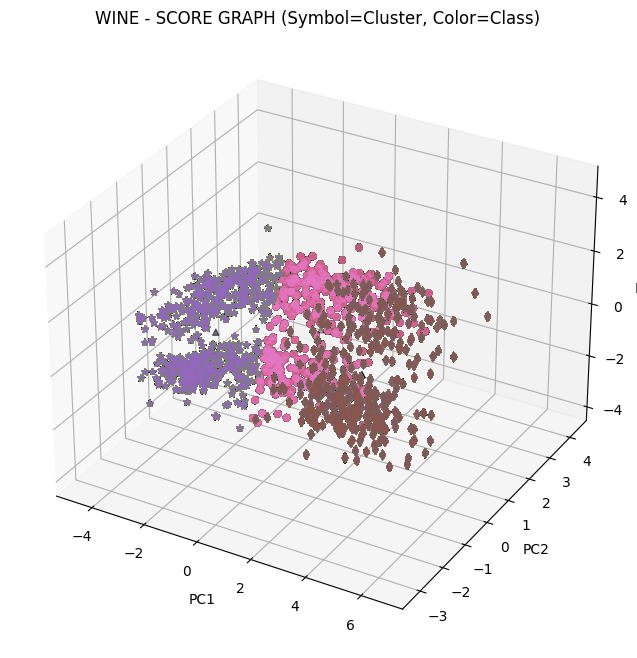

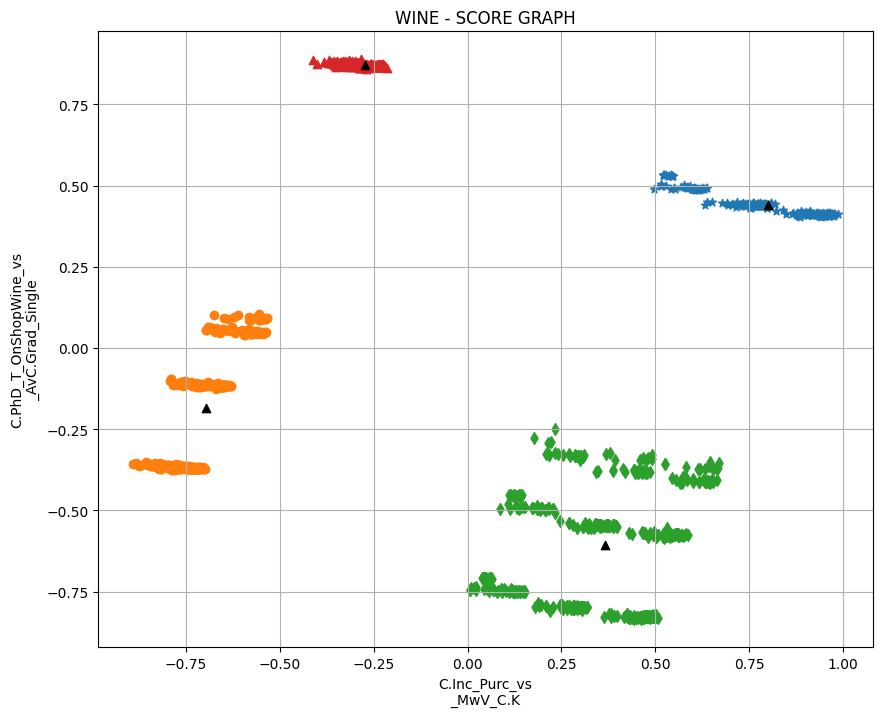

In [157]:
# markers_dict_std = {0: '*', 1: 'o', 2: 'd'}
markers_dict_std = {
    0: '*', 
    1: 'o', 
    2: 'd',

}
markers_dict_mm = {
    0: '*', 
    1: 'o', 
    2: 'd',
    3: '^',
}



fig_stdscore = plt.figure(figsize=(10, 8))
ax = fig_stdscore.add_subplot(111, projection='3d')
for ll in km_std.labels_:
    ax.scatter(Y_Xworkdf_std[:, 0:l_std][km_std.labels_ == ll, 0], Y_Xworkdf_std[:, 0:l_std][km_std.labels_ == ll, 1], Y_Xworkdf_std[:, 0:l_std][km_std.labels_ == ll, 2], marker=markers_dict_std[ll])
ax.scatter(km_std.cluster_centers_[:, 0], km_std.cluster_centers_[:, 1], km_std.cluster_centers_[:, 2], c='black', marker='^')
plt.title('WINE - SCORE GRAPH (Symbol=Cluster, Color=Class)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.grid()
plt.show()




fig_stdscore = plt.figure(figsize=(10, 8))
ax = fig_stdscore.add_subplot(111)
#for ll in km_mm.labels_:
for ll in np.unique(km_mm.labels_):
    ax.scatter(Y_Xworkdf_mm[km_mm.labels_ == ll, 0], Y_Xworkdf_mm[km_mm.labels_ == ll, 1], marker=markers_dict_mm[ll])
ax.scatter(km_mm.cluster_centers_[:, 0], km_mm.cluster_centers_[:, 1], c='black', marker='^')
plt.title('WINE - SCORE GRAPH')
ax.set_xlabel(f'{stdPC1}')
ax.set_ylabel(f'{stdPC2}')
plt.grid()
plt.show()





- External evaluation

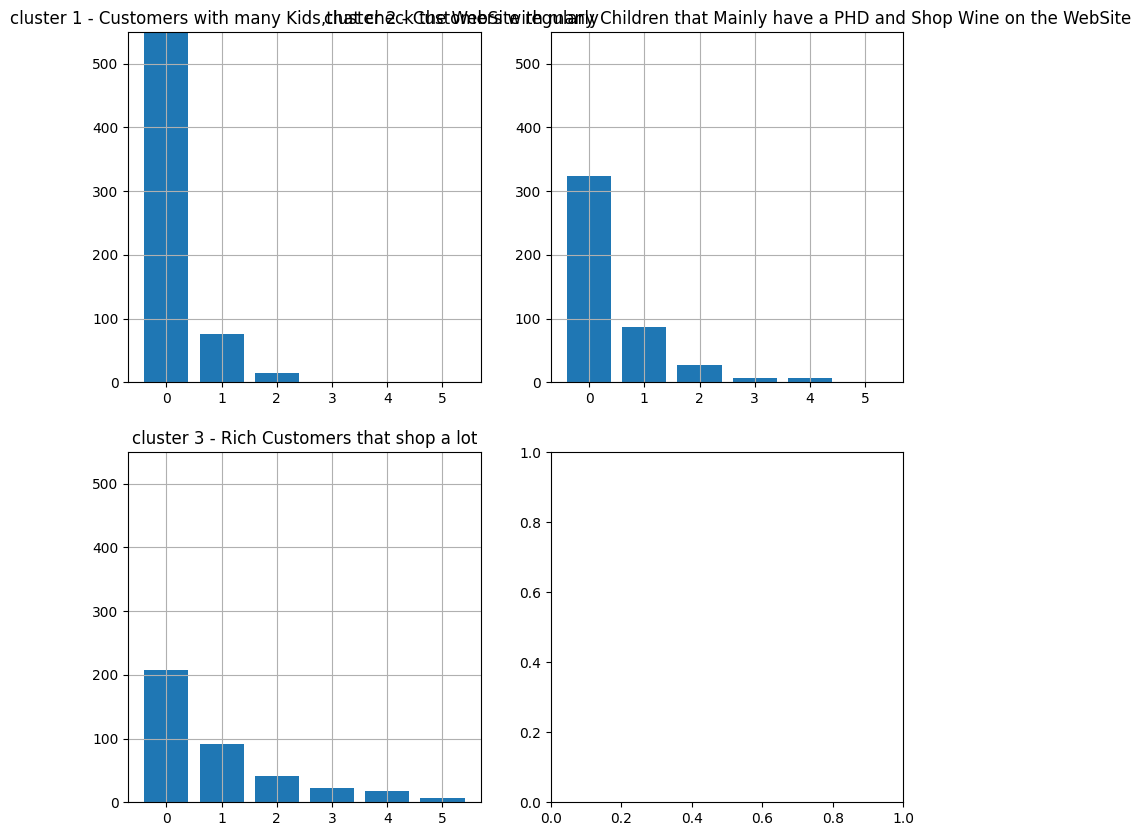

In [158]:
mask_cluster = [km_std.labels_ == ii for ii in range(best_k_std)]
cluster_complain = [dict(workdf.loc[mask_cluster[ii], 'Cmp'].value_counts()) for ii in range(best_k_std)]

bin_labels = [0, 1, 2, 3, 4, 5]
maxcount = np.max([max(cluster_complain[kk].values()) for kk in range(best_k_std)])

# MAKE the BARPLOT for THE CENTROIDS
fig_centroids_ext, ax_centroids_ext = plt.subplots(2, 2, figsize=(10,10))
for ii in range(best_k_std):
    ir = ii//2
    ic =  ii%2
    ax_centroids_ext[ir,ic].bar(bin_labels, [cluster_complain[ii].get(bb,0) for bb in bin_labels])
    ax_centroids_ext[ir,ic].set_ylim(0, maxcount)
    ax_centroids_ext[ir,ic].grid(visible=True, which='both')
    plt.tight_layout
    ax_centroids_ext[ir,ic].set_title(f'cluster {ii + 1} - {cluster_names_std[ii]}')

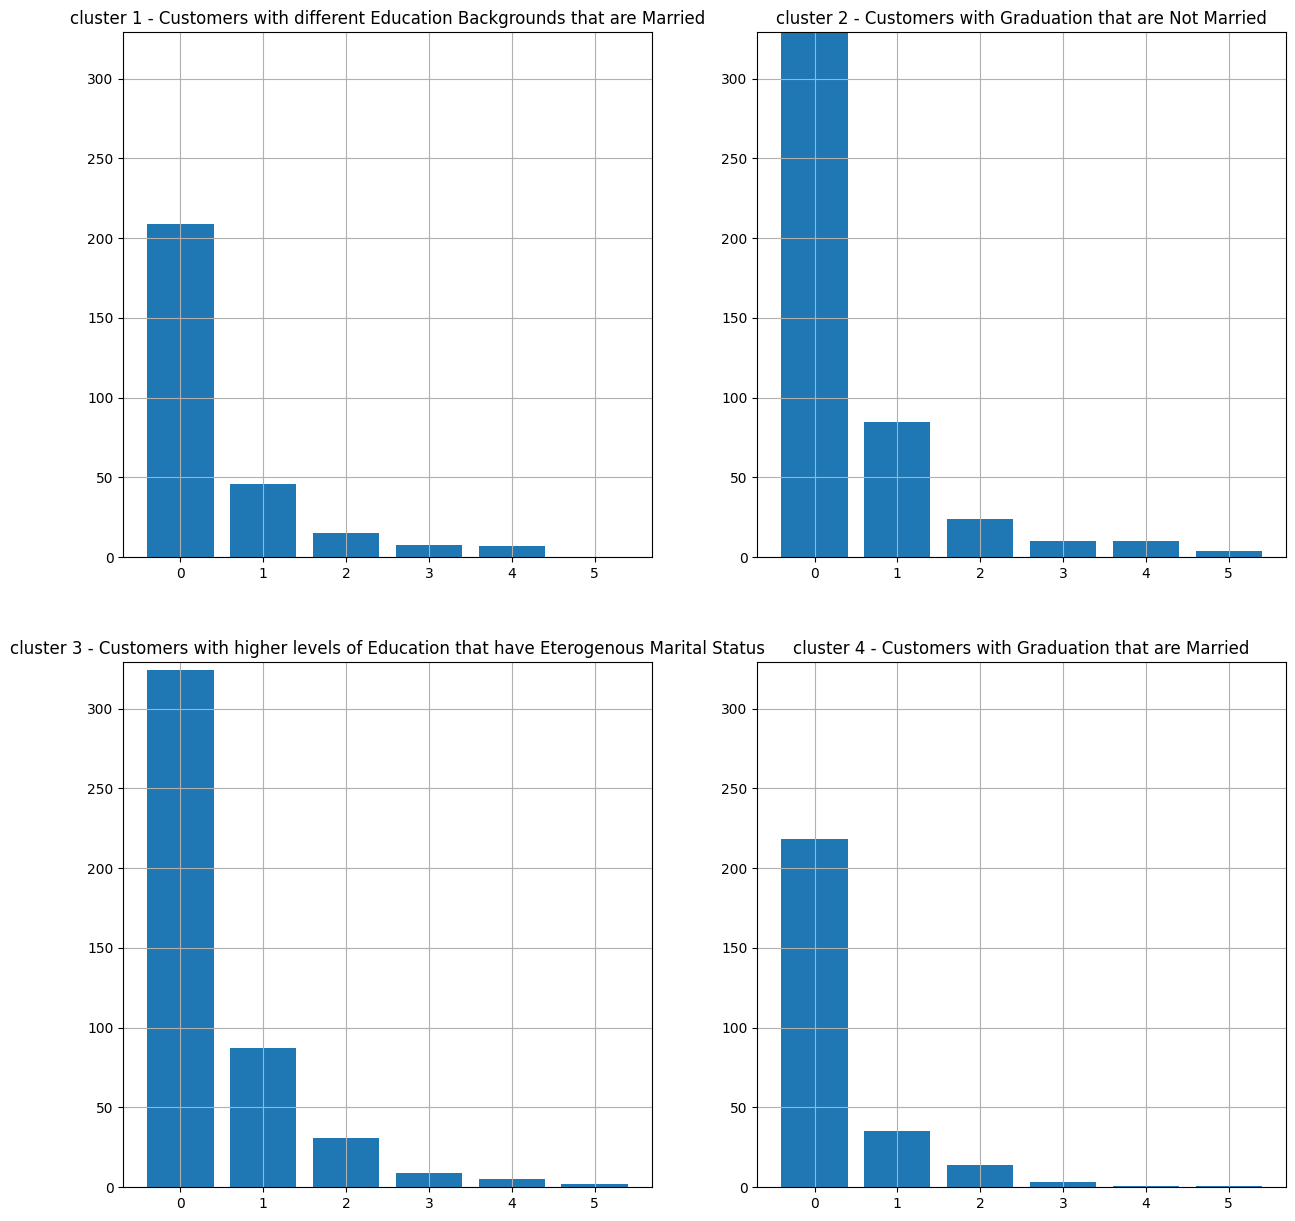

In [159]:
mask_cluster = [km_mm.labels_ == ii for ii in range(best_k_mm)]
cluster_complain = [dict(workdf.loc[mask_cluster[ii], 'Cmp'].value_counts()) for ii in range(best_k_mm)]

bin_labels = [0, 1, 2, 3, 4, 5]
maxcount = np.max([max(cluster_complain[kk].values()) for kk in range(best_k_mm)])

# MAKE the BARPLOT for THE CENTROIDS
fig_centroids_ext, ax_centroids_ext = plt.subplots(2, 2, figsize=(15,15))
for ii in range(best_k_mm):
    ir = ii//2
    ic =  ii%2
    ax_centroids_ext[ir,ic].bar(bin_labels, [cluster_complain[ii].get(bb,0) for bb in bin_labels])
    ax_centroids_ext[ir,ic].set_ylim(0, maxcount)
    ax_centroids_ext[ir,ic].grid(visible=True, which='both')
    plt.tight_layout
    ax_centroids_ext[ir,ic].set_title(f'cluster {ii + 1} - {cluster_names_mm[ii]}')

- Internal Evaluation

In [160]:
silscores_std = silhouette_samples(Y_Xworkdf_std[:,0:l_std], km_std.labels_)
cluster_silscores_std = [np.mean(np.array(silscores_std)[km_std.labels_ == kk]) for kk in range(best_k_std)]

display(pd.DataFrame(np.array(cluster_silscores_std + [np.max(silcoeff_list_std)]), index=cluster_names_std + ['Global'], columns=['Sil. Score']))

,Sil. Score
"Customers with many Kids,that check the WebSite regularly",0.403096
Customers with many Children that Mainly have a PHD and Shop Wine on the WebSite,0.257890
Rich Customers that shop a lot,0.352524
Global,0.345704


In [161]:
silscores_mm = silhouette_samples(Y_Xworkdf_mm[:,0:l_mm], km_mm.labels_)
cluster_silscores_mm = [np.mean(np.array(silscores_mm)[km_mm.labels_ == kk]) for kk in range(best_k_mm)]

display(pd.DataFrame(np.array(cluster_silscores_mm + [np.max(silcoeff_list_mm)]), index=cluster_names_mm + ['Global'], columns=['Sil. Score']))

,Sil. Score
Customers with different Education Backgrounds that are Married,0.844540
Customers with Graduation that are Not Married,0.790999
Customers with higher levels of Education that have Eterogenous Marital Status,0.701204
Customers with Graduation that are Married,0.961843
Global,0.804948
